## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

#%matplotlib qt
%matplotlib inline

In [3]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

def get_camera_calibration_parameters(globdir='./camera_cal/calibration*.jpg'):
     

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(globdir)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    assert len(objpoints) == len(imgpoints) # Check if same number of object and image point found

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist

def get_warp_parameters():
    ## TODO: Other solution for img.shape!
    img = mpimg.imread('./test_images/straight_lines2.jpg')
    src = np.float32(
        [(img.shape[1]/2-60, 450),
         (img.shape[1]/2+60, 450),
         (img.shape[1]-150, img.shape[0]-40),
         (150, img.shape[0]-40)])

    dst = np.float32(
        [(150, 200),
         (img.shape[1]-150, 200),
         (img.shape[1]-150, img.shape[0]),
         (150, img.shape[0])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    return M

ret, mtx, dist = get_camera_calibration_parameters()
M = get_warp_parameters()

In [289]:
# Helper classes
def undistort_img(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def birdview_warp(img, M=M):
    return cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)

def hist_equ(img):
    img_hist = img.copy()
    
    for n in range(img.shape[2]):
        #img_hist[:,:,n] = cv2.equalizeHist(img[:,:,n])
        img_hist[:,:,n] = exposure.equalize_hist(img[:,:,n])*255
    return img_hist


def sobel_parameters(img, 
                     thresh_abs_x = (0.1, 1), 
                     thresh_abs_y = (0.1, 1), 
                     thresh_mag = (0.1, 1), 
                     thresh_dir = (0, 1)):
    
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img[:,:,0].copy() ## use red channel
    
    # vertical contrast borders. Note that a Scharr kernel is used here for better performance 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
    
    # horizontal contrast borders. Scharr kernel
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
    
    # diagonal contrast borders high->low. Scharr kernel
    kernel10 = np.array([[0, -3, -10],[3, 0, -3],[10, 3, 0]]) 
    sobel10 = cv2.filter2D(gray, -1, kernel10)
    
    # diagonal contrast borders low->high. Scharr kernel
    kernel01 = np.array([[10, 3, 0],[3, 0, -3],[0, -3, -10]]) 
    sobel01 = cv2.filter2D(gray, -1, kernel01)
     
    # calculate value (sharpness) of contrast border and apply threshold to it
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # threshold values 
    scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
    binary_output_x = np.zeros_like(scaled_sobelx)
    binary_output_x[(scaled_sobelx >= thresh_abs_x[0]) & (scaled_sobelx <= thresh_abs_x[1])] = 1
    
    scaled_sobely = abs_sobely/np.max(abs_sobely)
    binary_output_y = np.zeros_like(scaled_sobely)
    binary_output_y[(scaled_sobely >= thresh_abs_y[0]) & (scaled_sobely <= thresh_abs_y[1])] = 1
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag = mag/np.max(mag)
    binary_output_mag = np.zeros_like(scaled_mag)
    binary_output_mag[(scaled_mag >= thresh_mag[0]) & (scaled_mag <= thresh_mag[1])] = 1
    
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_output_dir = np.zeros_like(dir_grad)
    binary_output_dir[(dir_grad > thresh_dir[0]) & (dir_grad <= thresh_dir[1])] = 1
    
    # put all binary images into one big numpy array
    bin_out = gray.copy()
    bin_out = np.dstack((bin_out, binary_output_x))
    bin_out = np.dstack((bin_out, binary_output_y))
    bin_out = np.dstack((bin_out, binary_output_mag))
    bin_out = np.dstack((bin_out, binary_output_dir))
    
    combined = np.zeros_like(binary_output_dir)
    combined[(bin_out[:,:,1] == 1) & (bin_out[:,:,2] == 1) & (bin_out[:,:,3] == 1) & (bin_out[:,:,4] == 1)] = 1
    bin_out = np.dstack((bin_out, combined))

    return bin_out

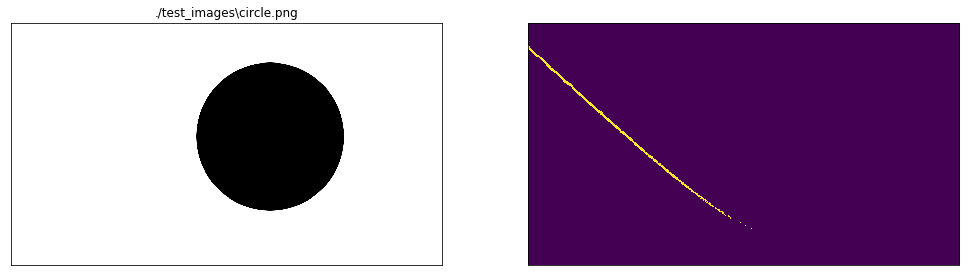

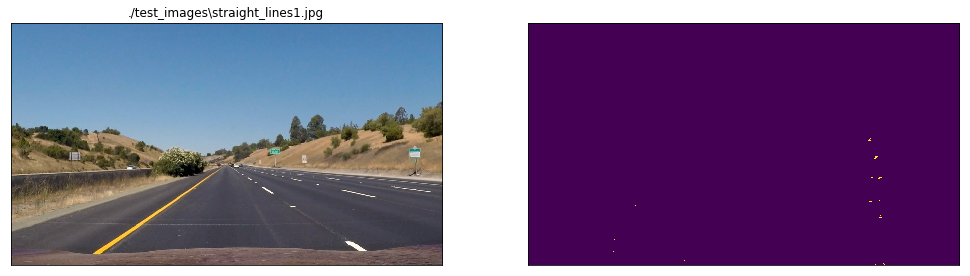

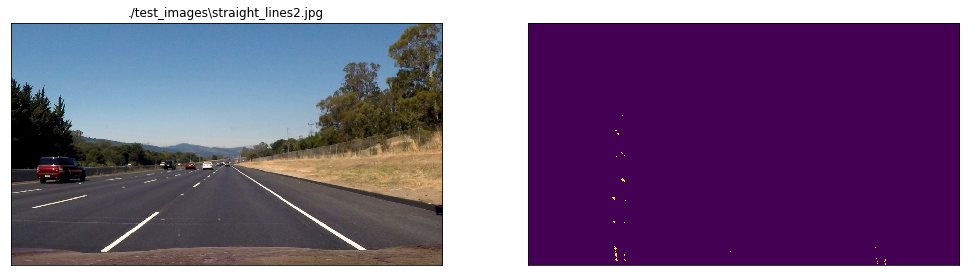

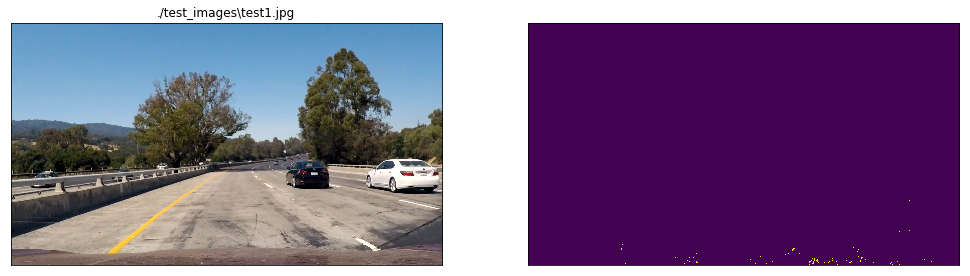

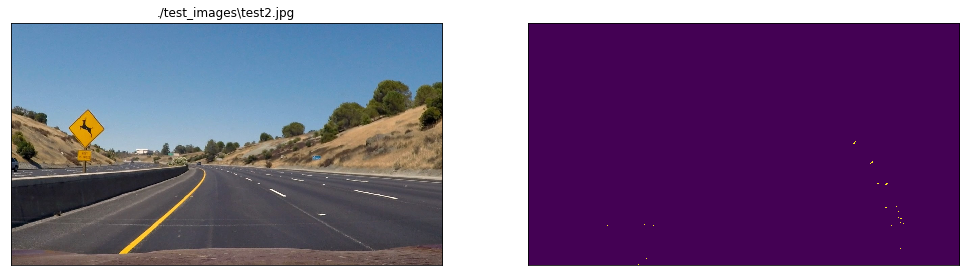

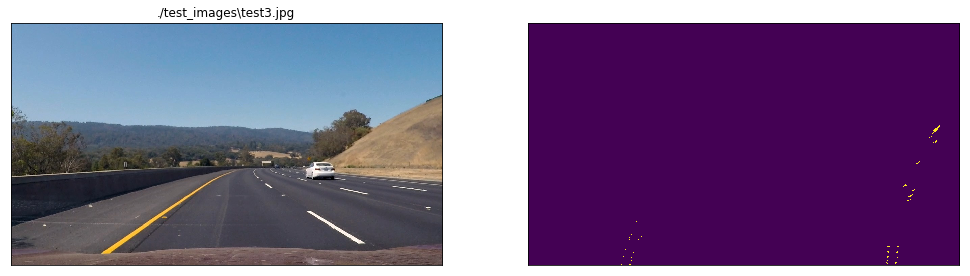

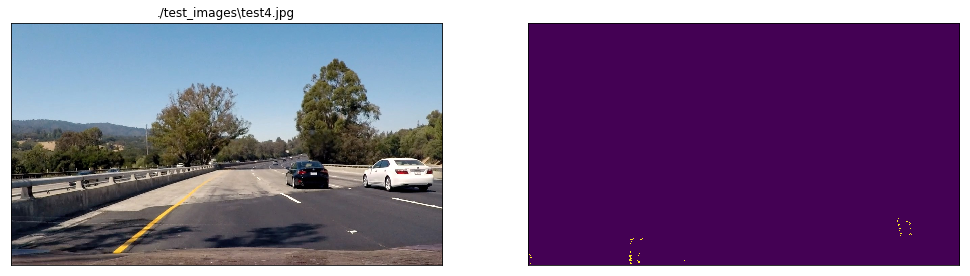

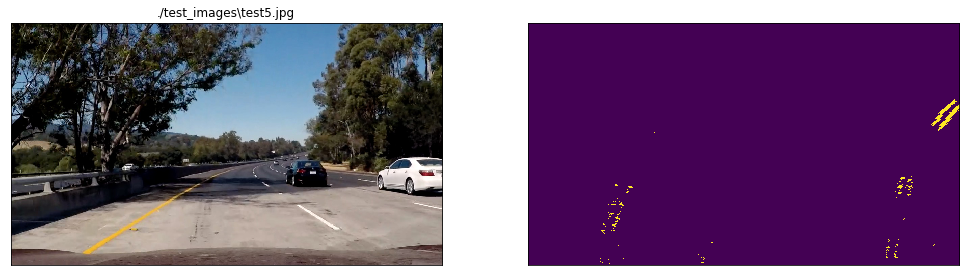

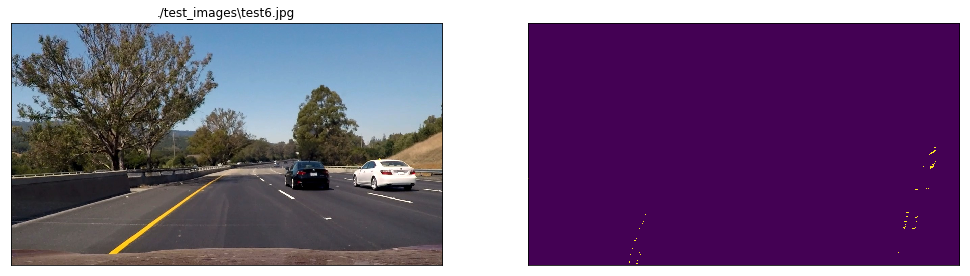

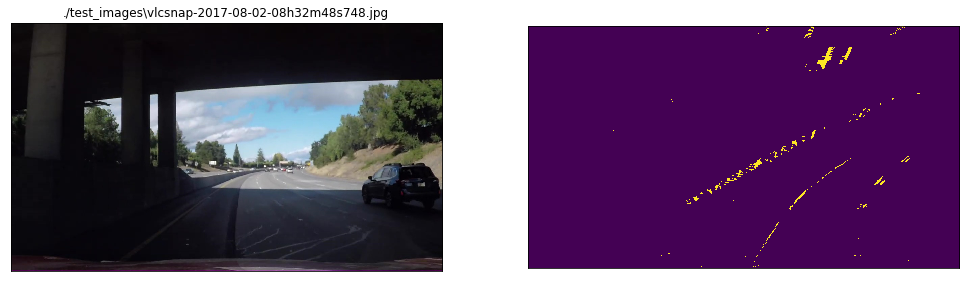

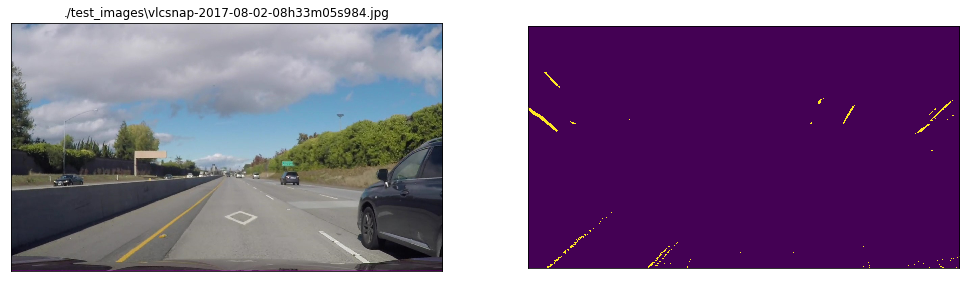

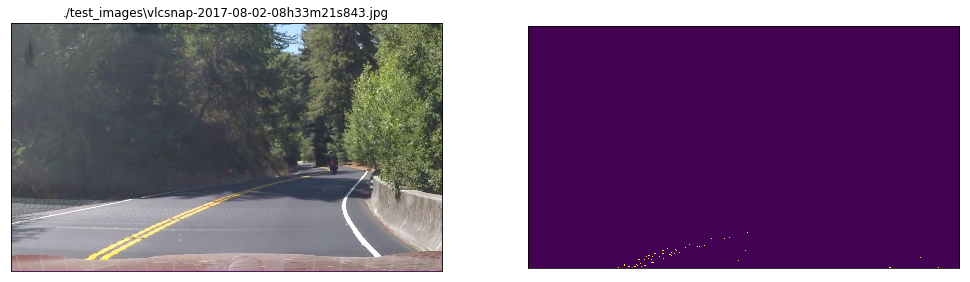

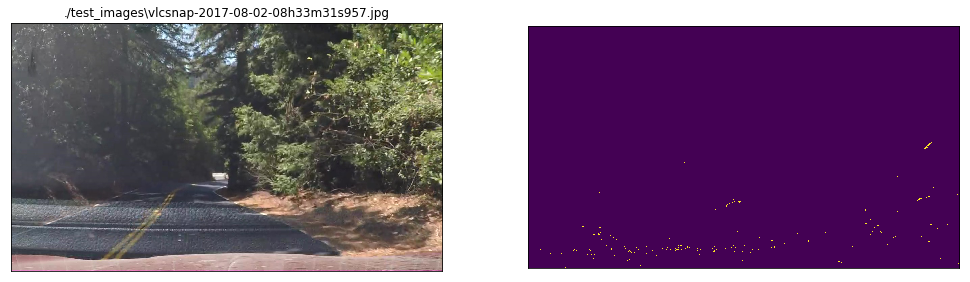

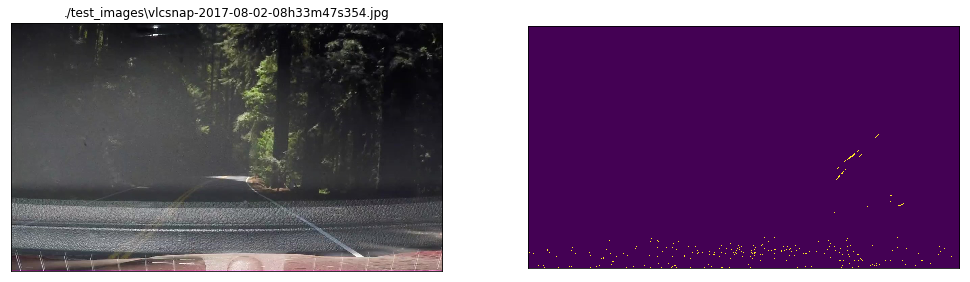

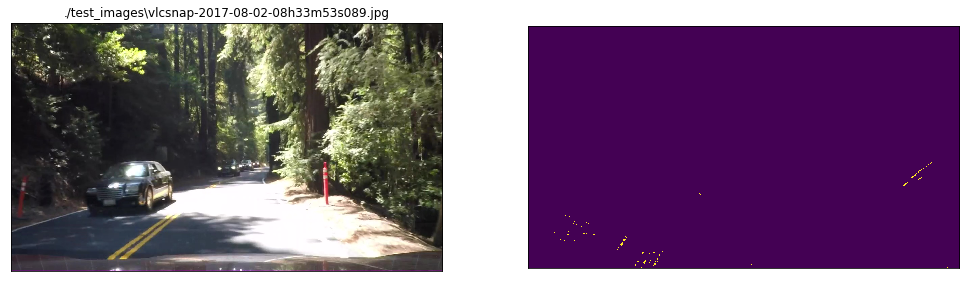

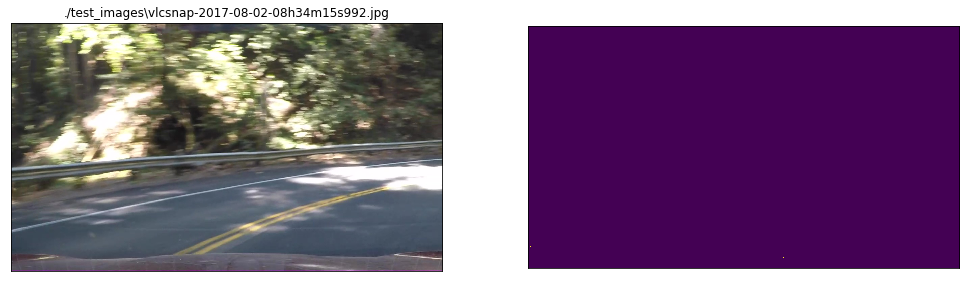

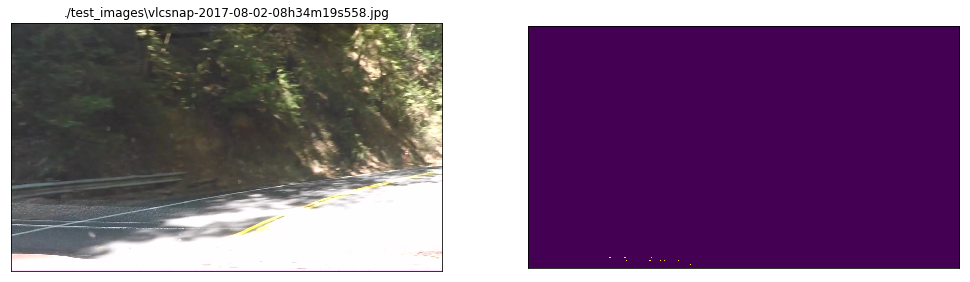

In [293]:
# define pipeline for lane detection
def pipeline_advanced_lane_finding(img):
    
    undist = undistort_img(img, mtx, dist)
    #equ = hist_equ(undist)
    birdview = birdview_warp(undist)
    sobel = sobel_parameters(birdview)[:,:,5]
    
    return sobel


#print all test images and how the pipeline works

images = glob.glob('./test_images/*')


for n, filename in enumerate(images):
    img = mpimg.imread(filename)
    plt.figure(figsize=(17,5))
    plt.subplot(1, 2, 1), plt.xticks([]), plt.yticks([])
    plt.title(filename)
    plt.imshow(img)
    dst = pipeline_advanced_lane_finding(img)
    plt.subplot(1, 2, 2), plt.xticks([]), plt.yticks([])
    plt.imshow(dst)



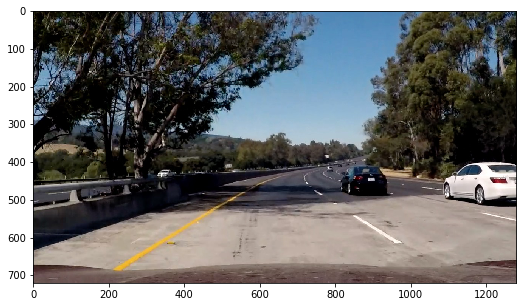

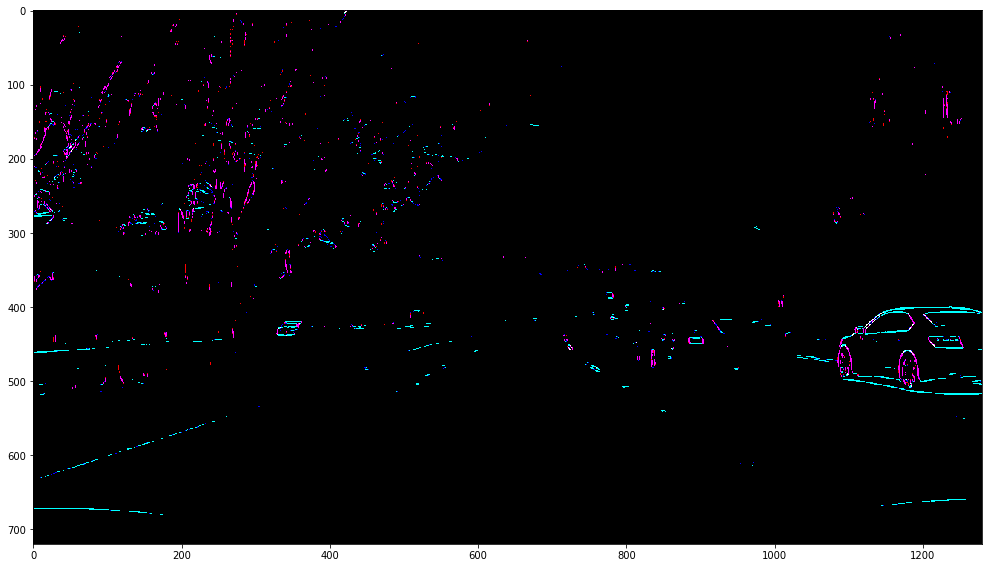

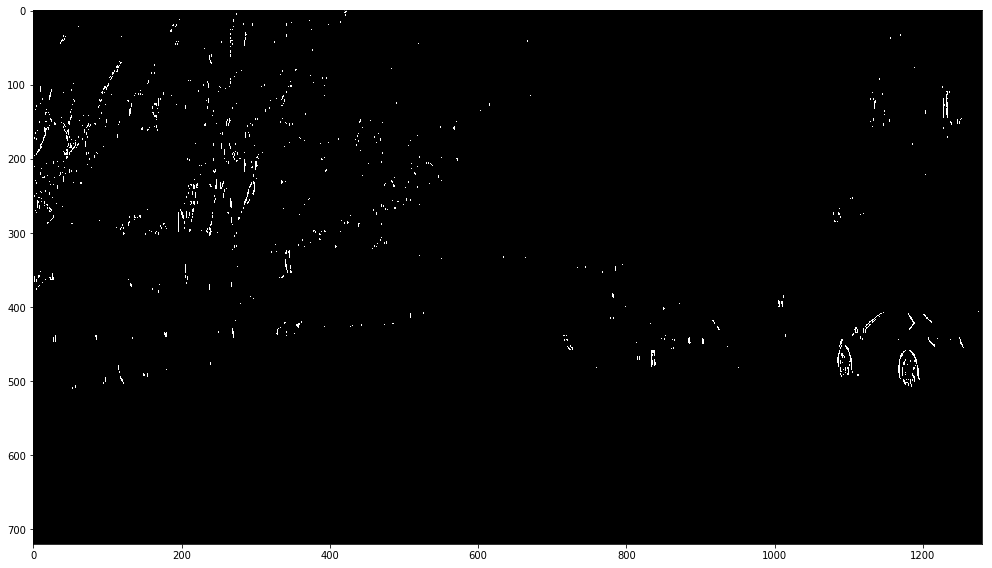

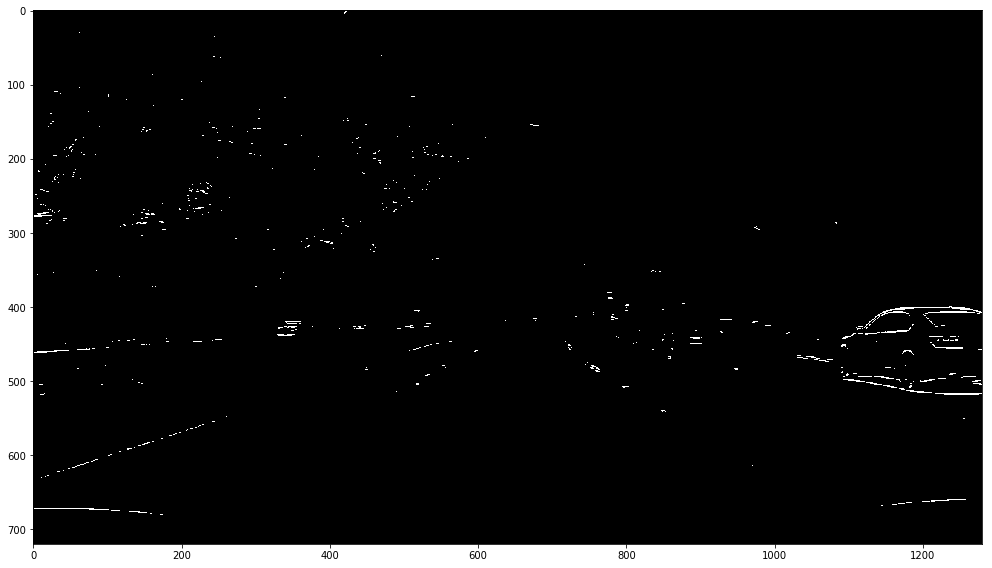

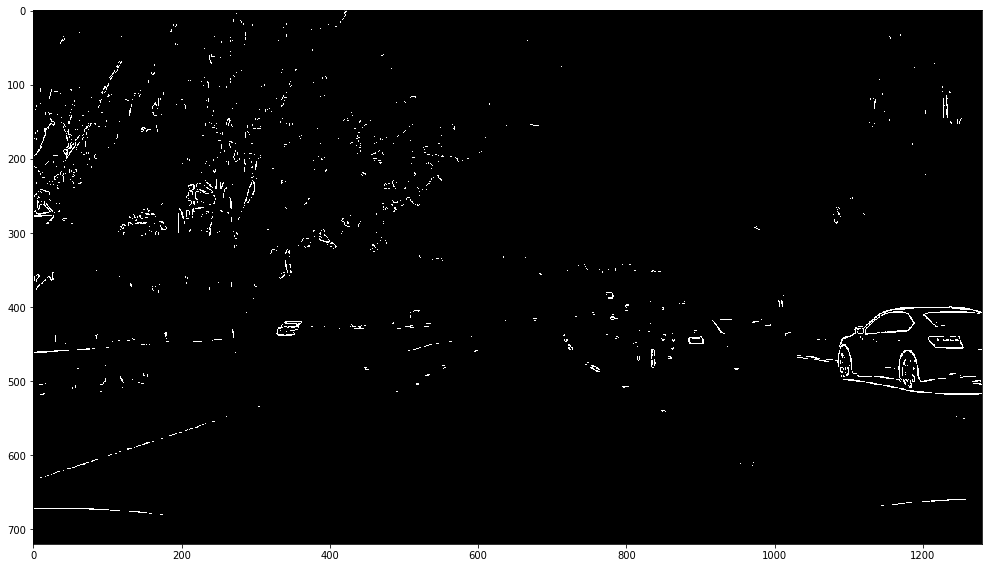

In [236]:
img = mpimg.imread('./test_images/test5.jpg')
plt.figure(figsize=(17,5))
plt.imshow(img)

bin_out = sobel_parameters(img)
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,1:4], cmap='gray')


plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,1], cmap='gray')
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,2], cmap='gray')
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,3], cmap='gray')

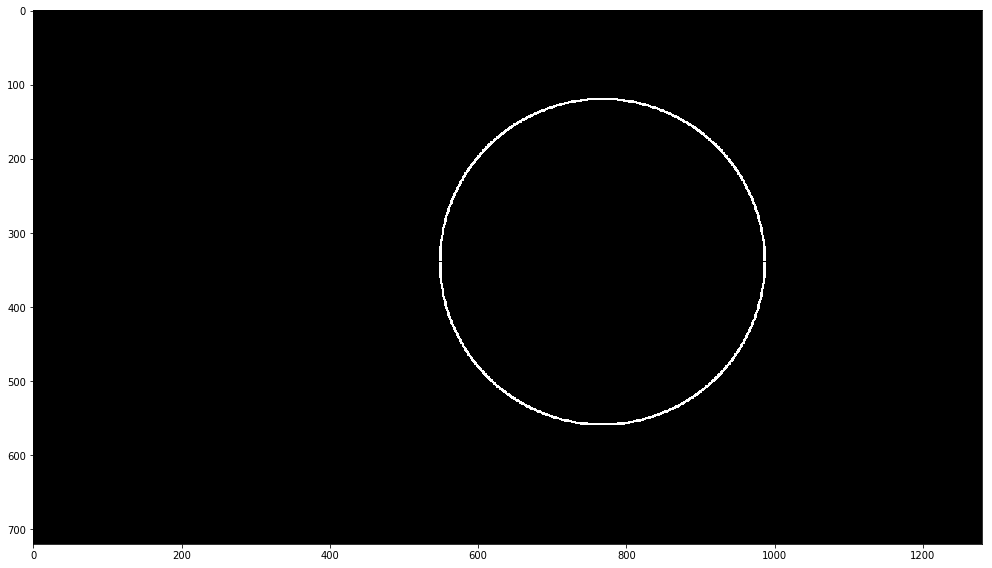

In [284]:
from IPython.html.widgets import *


def sobel(thresh_abs_x_low = 0, thresh_abs_x_high = 1,
         thresh_abs_y_low = 0, thresh_abs_y_high = 1, 
         thresh_mag_low = 0, thresh_mag_high = 1,
         thresh_dir_low = 0, thresh_dir_high=1):
    
    img = mpimg.imread('./test_images/circle.png')
    bin_out = sobel_parameters(img, 
                               thresh_abs_x = (thresh_abs_x_low, thresh_abs_x_high), 
                                thresh_abs_y = (thresh_abs_y_low, thresh_abs_y_high), 
                                thresh_mag = (thresh_mag_low, thresh_mag_high), 
                                thresh_dir = (thresh_dir_low, thresh_dir_high))
    
    plt.figure(figsize=(17,10))
    plt.imshow(bin_out[:,:,5], cmap='gray')
    plt.show()
    return

interact(sobel, thresh_abs_x_low = (0,1,0.01), thresh_abs_x_high = (0,1,0.01),
         thresh_abs_y_low = (0,1,0.01), thresh_abs_y_high = (0,1,0.01), 
         thresh_mag_low = (0,1,0.01), thresh_mag_high = (0,1,0.01),
         thresh_dir_low = (0,1.57,0.01), thresh_dir_high= (0,1.57,0.01))

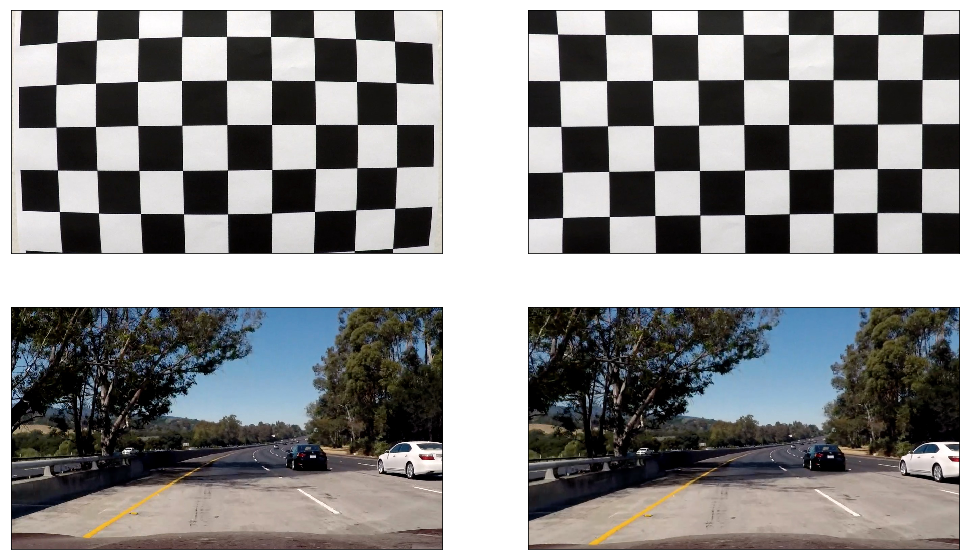

In [122]:
## undistortion demo
plt.figure(figsize=(17,10))
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.subplot(221), plt.xticks([]), plt.yticks([])
plt.imshow(img)
dst = undistort_img(img, mtx, dist)
plt.subplot(222), plt.xticks([]), plt.yticks([])
plt.imshow(dst)

img = mpimg.imread('./test_images/test5.jpg')
plt.subplot(223), plt.xticks([]), plt.yticks([])
plt.imshow(img)
dst = undistort_img(img, mtx, dist)
plt.subplot(224), plt.xticks([]), plt.yticks([])
plt.imshow(dst)

plt.show()

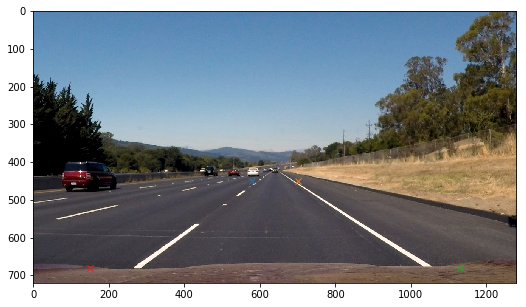

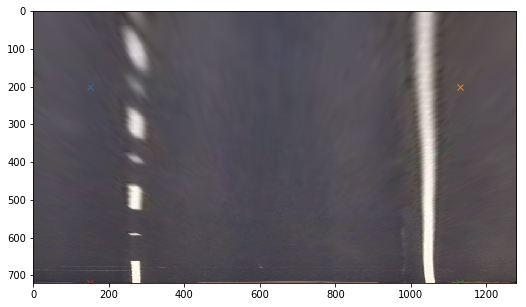

In [7]:
## Image warping demo
img = mpimg.imread('./test_images/straight_lines2.jpg')
plt.figure(figsize=(17,5))
plt.imshow(img)


src = np.float32(
    [(img.shape[1]/2-60, 450),
     (img.shape[1]/2+60, 450),
     (img.shape[1]-150, img.shape[0]-40),
     (150, img.shape[0]-40)])

for n in range(4):
    plt.plot(src[n][0], src[n][1], 'x')

    
dst = np.float32(
    [(150, 200),
     (img.shape[1]-150, 200),
     (img.shape[1]-150, img.shape[0]),
     (150, img.shape[0])])

plt.figure(figsize=(17,5))
img_size = (img.shape[1], img.shape[0])
for n in range(4):
    plt.plot(dst[n][0], dst[n][1], 'x')



M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)
plt.imshow(warped)


(720, 1280) 16.0 -16.0
(720, 1280, 5)


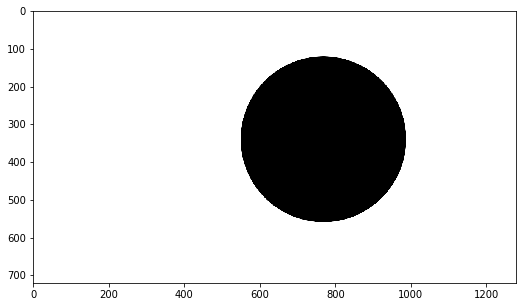

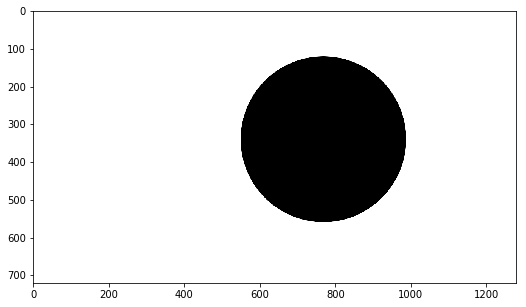

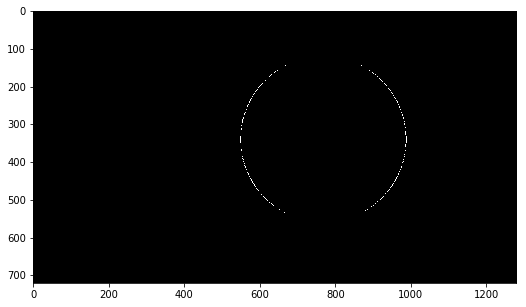

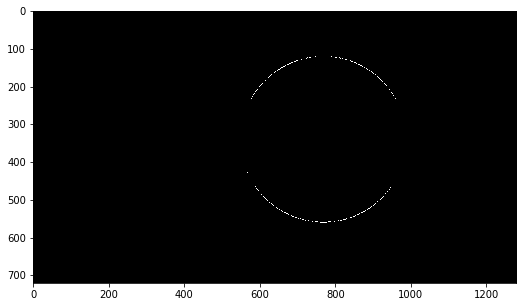

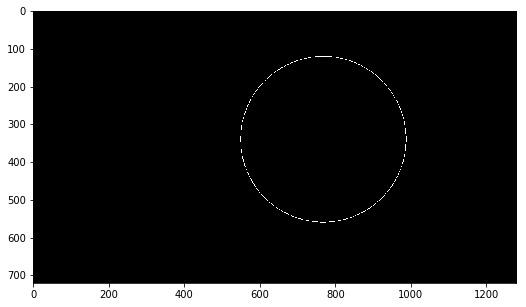

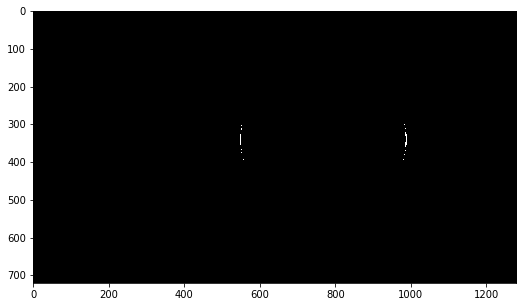

In [208]:
## sobel demo
img = mpimg.imread('./test_images/circle.png')
plt.figure(figsize=(17,5))
plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
print(sobelx.shape, sobelx.max(), sobelx.min())
placeholder = gray.copy()

# set parameters
thresh_abs_x = (150, 255)
thresh_abs_y = (150, 255)
thresh_mag = (150, 255)
thresh_dir = (0, 0.1)

# abs
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
binary_output_x = np.zeros_like(scaled_sobelx)
binary_output_x[(scaled_sobelx > thresh_abs_x[0]) & (scaled_sobelx < thresh_abs_x[1])] = 1
placeholder = np.dstack((placeholder, binary_output_x))

abs_sobely = np.absolute(sobely)
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
binary_output_y = np.zeros_like(scaled_sobely)
binary_output_y[(scaled_sobely > thresh_abs_y[0]) & (scaled_sobely < thresh_abs_y[1])] = 1
placeholder = np.dstack((placeholder, binary_output_y))

# mag
mag = np.sqrt(sobelx**2 + sobely**2)
scaled_mag = np.uint8(255*mag/np.max(mag))
binary_output_mag = np.zeros_like(scaled_mag)
binary_output_mag[(scaled_mag > thresh_mag[0]) & (scaled_mag < thresh_mag[1])] = 1
placeholder = np.dstack((placeholder, binary_output_mag))

# direction
#thresh_dir = (thresh_dir*np.pi)-(np.pi/2)
dir_grad = np.arctan2(abs_sobely, abs_sobelx)
binary_output_dir = np.zeros_like(dir_grad)
binary_output_dir[(dir_grad > thresh_dir[0]) & (dir_grad <= thresh_dir[1])] = 1
placeholder = np.dstack((placeholder, binary_output_dir))


plt.figure(figsize=(17,5))
plt.imshow(gray, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_x, cmap='gray')


plt.figure(figsize=(17,5))
plt.imshow(binary_output_y, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_mag, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_dir, cmap='gray')

print(placeholder.shape)

In [213]:
abs_sobelx = np.absolute(sobelx)
print(abs_sobelx.min(), abs_sobelx.max())
scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
print(scaled_sobelx.min(), scaled_sobelx.max())
binary_output_x = np.zeros_like(scaled_sobelx)
binary_output_x[(scaled_sobelx >= thresh_abs_x[0]) & (scaled_sobelx <= thresh_abs_x[1])] = 1
placeholder = np.dstack((placeholder, binary_output_x))

0.0 16.0
0.0 1.0


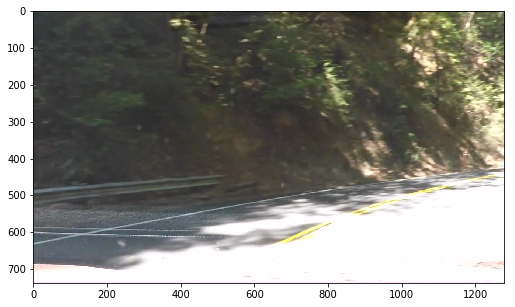

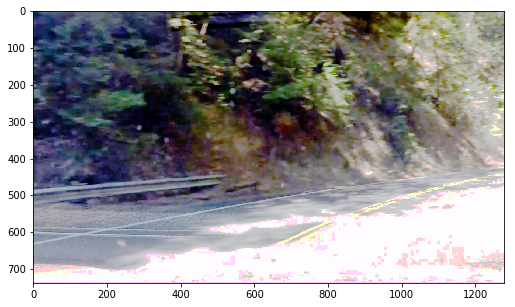

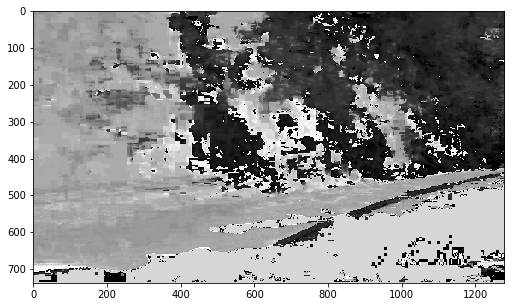

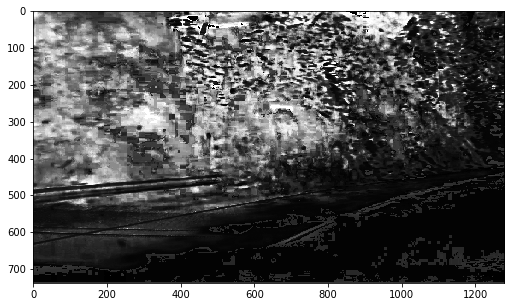

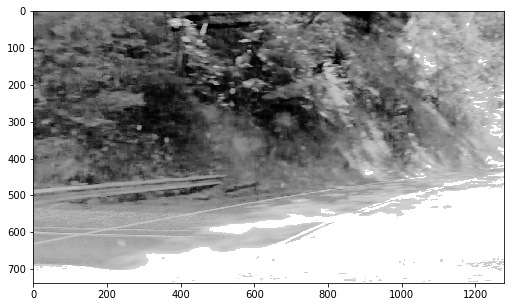

In [200]:
# color space demo
from skimage import exposure

img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h34m19s558.jpg')
plt.figure(figsize=(17,5))
plt.imshow(img)
img = hist_equ(img)

plt.figure(figsize=(17,5))
plt.imshow(img)

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#img_hsv= img

plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,0], cmap='gray')
plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,1], cmap='gray')
plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,2], cmap='gray')

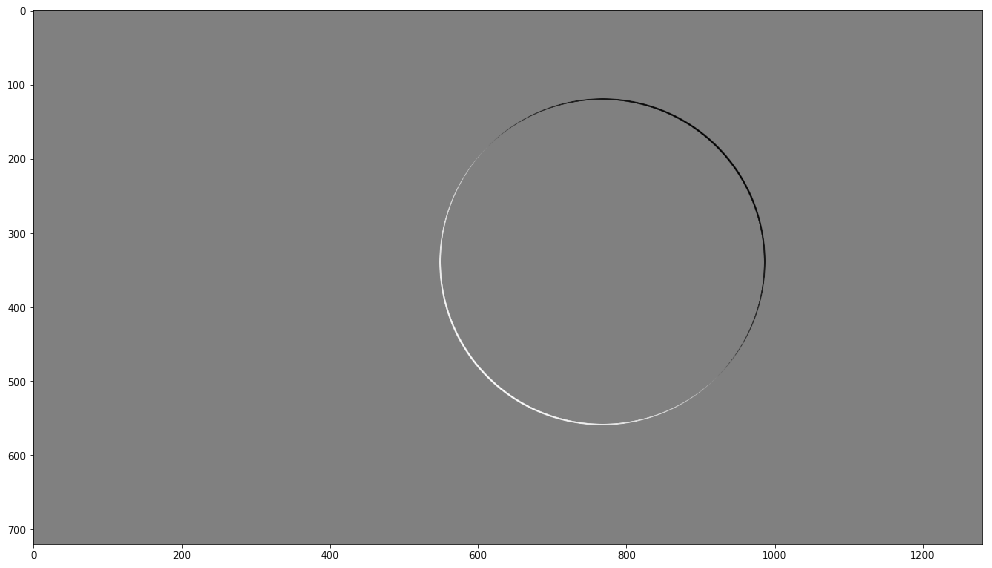

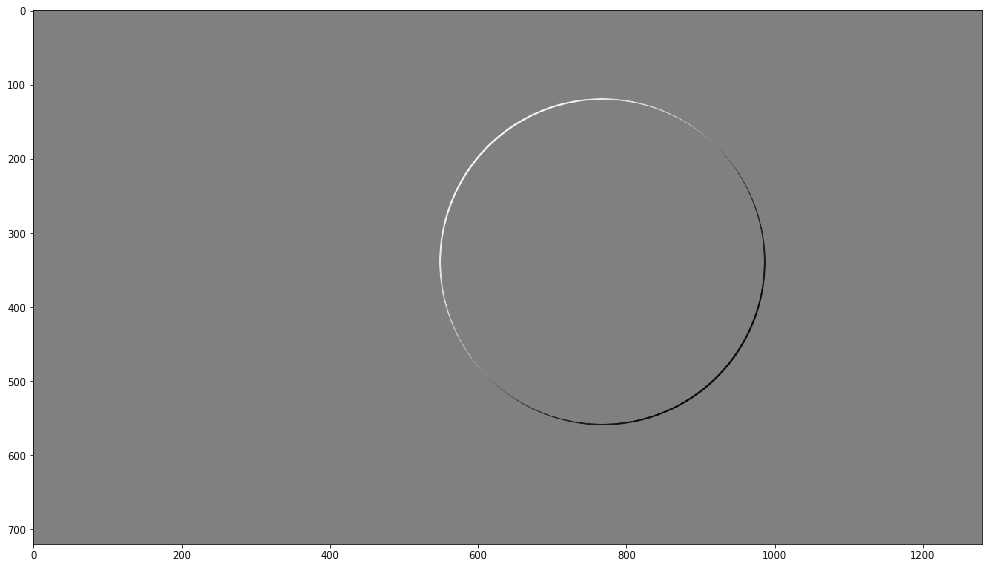

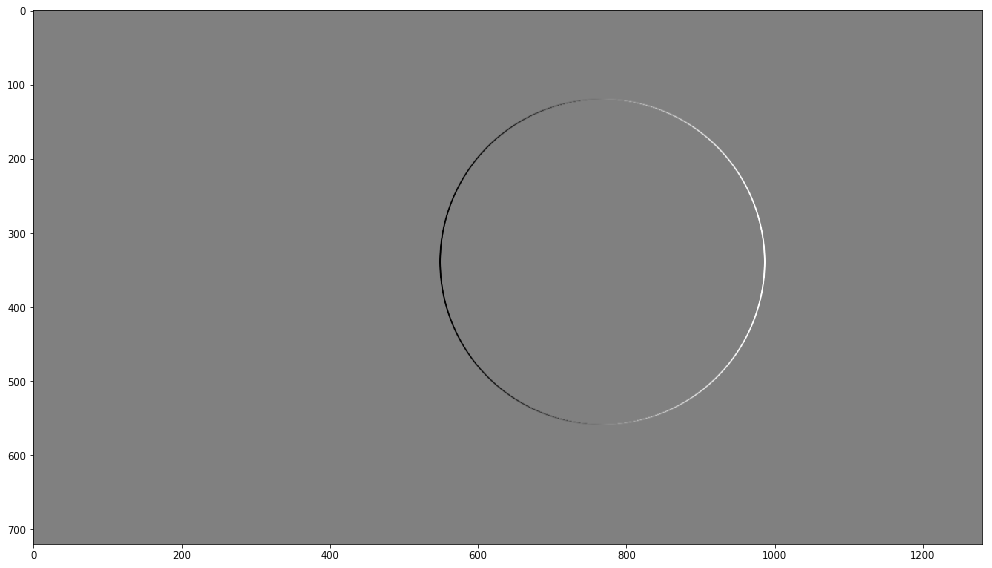

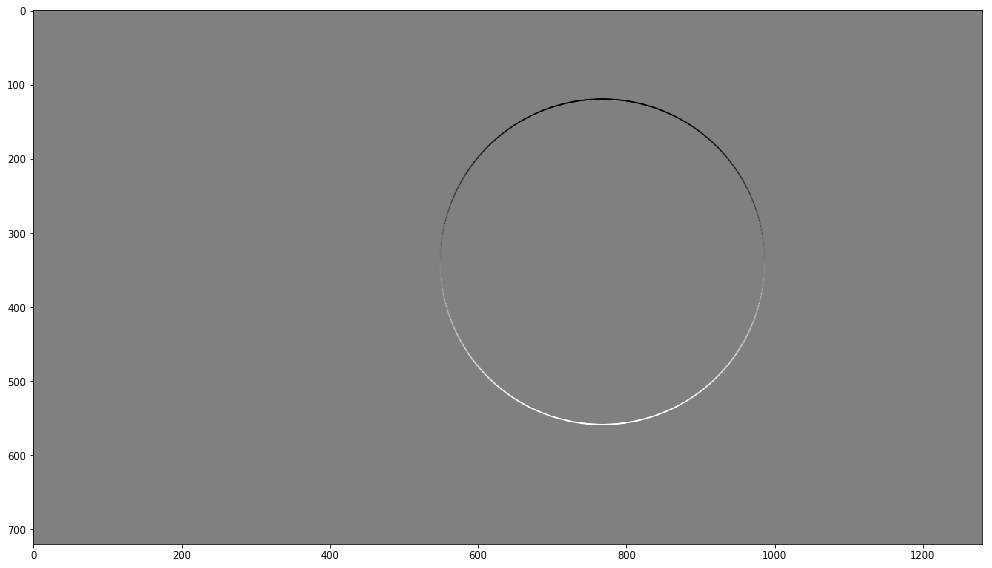

In [163]:
# test with custom sobel kernel
img = mpimg.imread('./test_images/circle.png')

kernel10 = np.array([[0, -3, -10],[3, 0, -3],[10, 3, 0]]) 

kernel01 = np.array([[10, 3, 0],[3, 0, -3],[0, -3, -10]]) 

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

sobel_custom1 = cv2.filter2D(gray, -1, kernel10)
plt.figure(figsize=(17,10))
plt.imshow(sobel_custom1, cmap='gray')

sobel_custom2 = cv2.filter2D(gray, -1, kernel01)
plt.figure(figsize=(17,10))
plt.imshow(sobel_custom2, cmap='gray')

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
plt.figure(figsize=(17,10))
plt.imshow(sobelx, cmap='gray')

sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
plt.figure(figsize=(17,10))
plt.imshow(sobely, cmap='gray')